# Three-Dimensional ECM Plots
Make 3D plots of ALHIC1901 228_4 and 230_4

## Import Data

In [1]:
# general
import numpy as np
import pandas as pd
from tqdm import tqdm

# plotting
#%matplotlib tk
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM
from ECMclass import core_section

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Setup

In [2]:
# Set filepaths

path_to_data = '../../data/ecm/'
path_to_figures = '../../../figures/'

In [3]:
# smoothing window
window = 10

## Load Data

In [4]:
# Load metadata
meta = pd.read_csv(path_to_data + 'metadata.csv')
meta.head()

,core,time,section,face,ACorDC,Y_left,Y_right,AC_edgespace,DC_edgespace
0,alhic1901,cmc1,230_4,t,DC,-5.080,206.763,15,10
1,alhic1901,cmc1,230_4,l,DC,70.404,170.096,15,10
2,alhic1901,cmc1,228_4,t,DC,-10.000,192.000,15,10
3,alhic1901,cmc1,228_4,l,AC,63.881,166.250,15,10
4,alhic1901,cmc1,228_4,l,DC,65.891,149.177,15,10


In [5]:
# Load ECM data

data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing data"):
    
    core = row['core']
        
    section = row['section']
    face = row['face']
    ACorDC = row['ACorDC']

    data_item = ECM(core,section,face,ACorDC)
    print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
    
    data_item.rem_ends(15)
    data_item.smooth(window)
    data.append(data_item)
    
    cores.append(core)
    sections.append(section)
    faces.append(face)
    ACorDCs.append(ACorDC)

Processing data:   0%|          | 0/13 [00:00<?, ?it/s]

Reading alhic1901, section 230_4-t-DC


Processing data:  23%|██▎       | 3/13 [00:00<00:01,  5.91it/s]

Reading alhic1901, section 230_4-l-DC
Reading alhic1901, section 228_4-t-DC


Processing data:  31%|███       | 4/13 [00:00<00:01,  6.13it/s]

Reading alhic1901, section 228_4-l-AC
Reading alhic1901, section 228_4-l-DC


Processing data:  46%|████▌     | 6/13 [00:00<00:01,  6.92it/s]

Reading alhic1901, section 230_4-l-AC
Reading alhic1901, section 230_4-t-AC


Processing data:  54%|█████▍    | 7/13 [00:01<00:01,  3.52it/s]

Reading alhic1901, section 230_4-r-DC
Reading alhic1901, section 230_4-r-AC


Processing data:  69%|██████▉   | 9/13 [00:01<00:00,  4.73it/s]

Reading alhic1901, section 228_4-r-DC
Reading alhic1901, section 228_4-r-AC


Processing data:  85%|████████▍ | 11/13 [00:02<00:00,  5.70it/s]

Reading alhic1901, section 228_4-o-AC


Processing data:  92%|█████████▏| 12/13 [00:02<00:00,  5.16it/s]

Reading alhic1901, section 228_4-t-AC


Processing data: 100%|██████████| 13/13 [00:02<00:00,  4.78it/s]


In [6]:
# Put ECM data into core_section structure

s228_4 = core_section('228_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)
s230_4 = core_section('230_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)

# place in 3D space
for s in [s228_4,s230_4]:
    s.add_3d_coords()

In [7]:
print(s228_4.left.y_left)
print(s228_4.left.y_right)

63.881
166.25


## Make 3D Plot




In [8]:
# setup

# colormap
cmap = matplotlib.colormaps['Spectral']

# fontsize
fsz = 12

In [9]:
# make function to draw outline
def draw_outline(radius, d_min, d_max, ax, leftorright):
    
    angle_resolution = 50
    
    # Generate points in the xz-plane (side surface)
    if leftorright=='left':
        theta = np.linspace(1*np.pi/2, 2*np.pi / 2, angle_resolution)
    elif leftorright=='right':
        theta = np.linspace(0*np.pi/2, 1*np.pi / 2, angle_resolution)
    else:
        print("Error - invalid input to drawoutline function")
        
    x = radius * np.cos(theta)
    z = radius * np.sin(theta)
    
    # set sign of outlying points
    if leftorright=='left':
        r=-radius
    elif leftorright=='right':
        r=radius
    else:
        print("Error - invalid input to drawoutline function")


    
    # Plot the ront side curve
    ax.plot(x, d_max * np.ones_like(x), z, color='k')
    # Plot the back side curve
    ax.plot(x, d_min*np.ones_like(x), z, color='k')
    # Plot the Bottom Edge
    ax.plot([0,0],[d_min, d_max],[radius,radius],color='k')
    # Plot the Top Edge
    ax.plot([0,0],[d_min, d_max],[0,0],color='k')
    # Plot the Ouside Edge
    ax.plot([r,r],[d_min, d_max],[0,0],color='k')
    # plot the front edge
    ax.plot([r,0],[d_min, d_min],[0,0],color='k')
    # plot the back edge
    ax.plot([r,0],[d_max, d_max],[0,0],color='k')
    # plot the front upright edge
    ax.plot([0,0],[d_max, d_max],[0,radius],color='k')
    # plot the back upright edge
    ax.plot([0,0],[d_min, d_min],[0,radius],color='k')

Running section 228_4
    Running face t
    Running face l
    Running face t
    Running face r


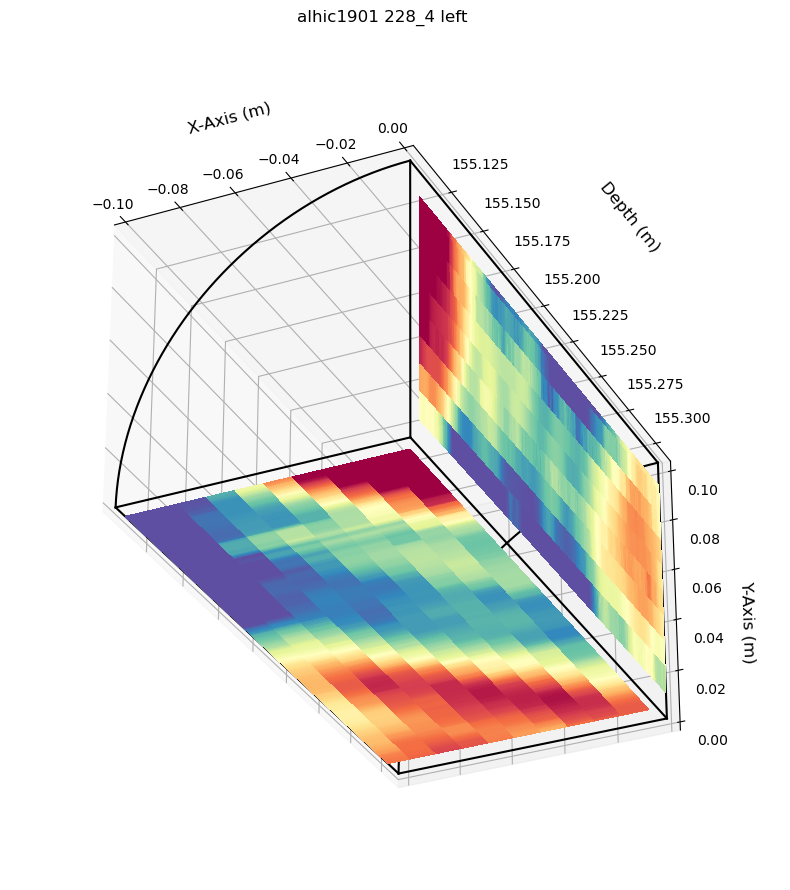

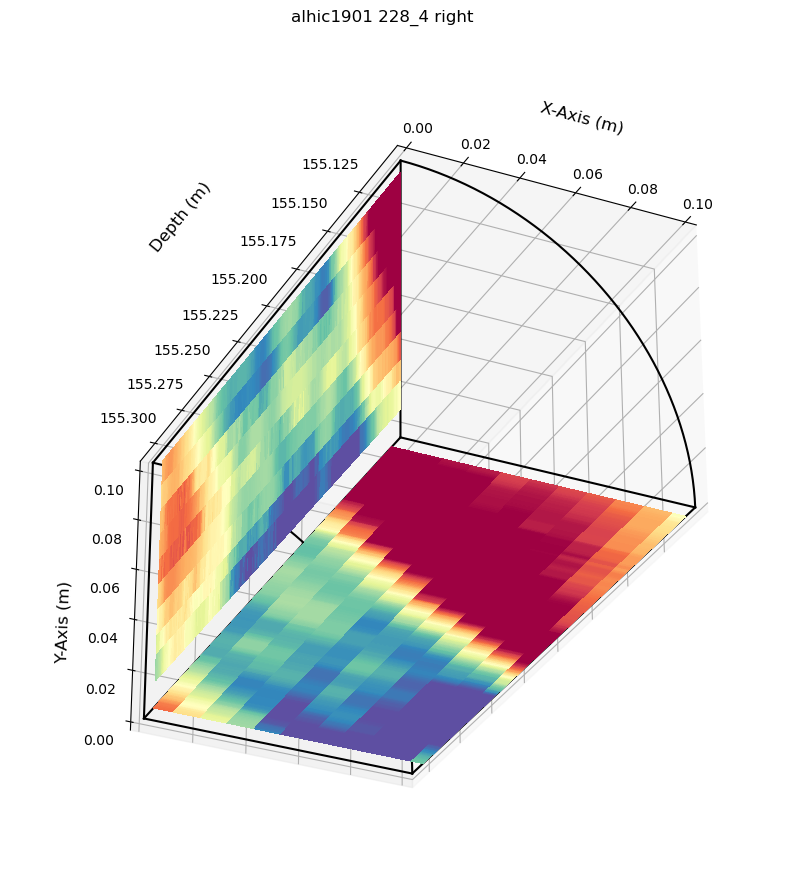

Running section 230_4
    Running face t
    Running face l
    Running face t
    Running face r


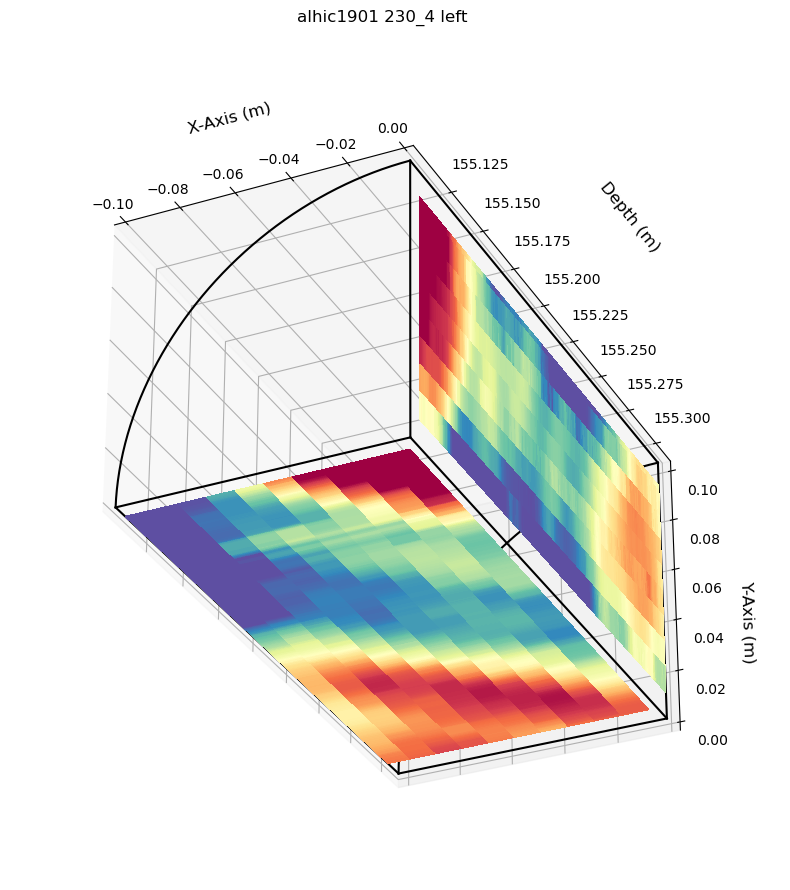

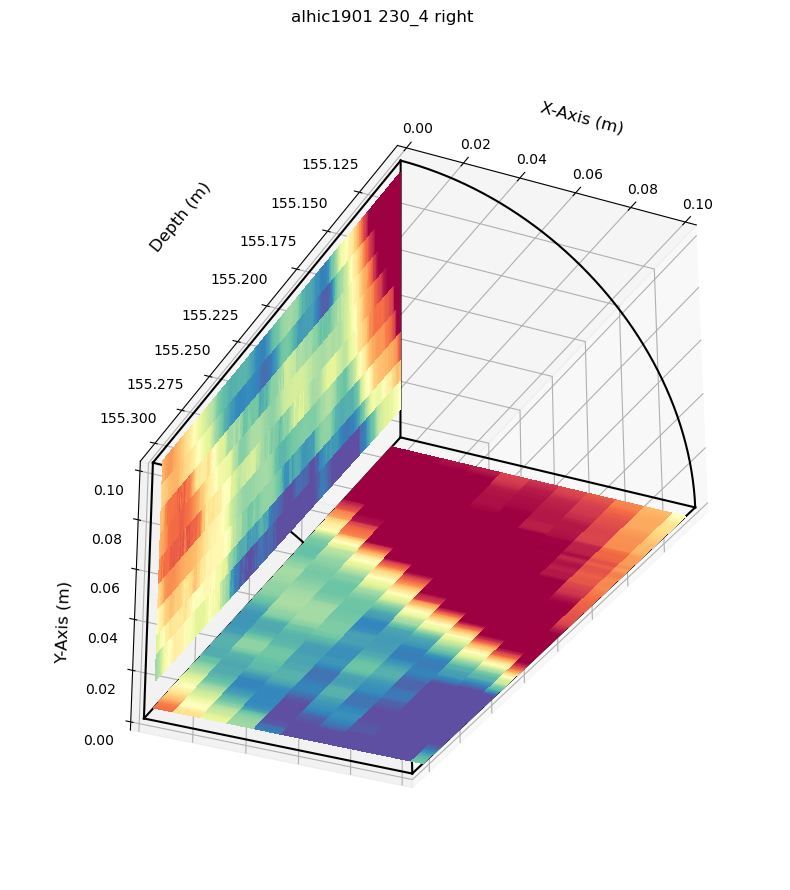

In [15]:
# loop through sections
for s in [s228_4,s230_4]:

    print("Running section "+s.section)

    # make colorscale
    meas_all = np.concatenate((s.top.meas, s.left.meas, s.right.meas)) 
    pltmin = np.percentile(meas_all,10)
    pltmax = np.percentile(meas_all,90)
    rescale = lambda k: (k-pltmin) /  (pltmax-pltmin)

    # Define the parameters for the quarter cylinder
    radius = max([max(abs(s.top.x_3d)),max(abs(s.left.y_3d)),max(abs(s.right.y_3d))])

    # get min and max depth accross all faces
    d_min = min([min(s.left.depth_s),
                  min(s.top.depth_s),
                  min(s.right.depth_s)])
    d_max = max([max(s.left.depth_s),
                  max(s.top.depth_s),
                  max(s.right.depth_s)])

    for side in ['left','right']:

        # make figure
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_box_aspect([1,1,1])

        # let's plot ECM data
        if side == 'right':
            faces = [s.top,s.right]
            face_names = ['t','r']
        else:
            faces = [s.top,s.left]
            face_names = ['t','l']

        # loop through and plot each face
        for f,n in zip(faces,face_names):

            print("    Running face "+n)

            for i in range(len(f.y_vec)):

                # get data from this track
                meas = f.meas_s[f.y_s==f.y_vec[i]]
                depth = f.depth_s[f.y_s==f.y_vec[i]]
                x_3d = f.x_3d[f.y_s==f.y_vec[i]]
                y_3d = f.y_3d[f.y_s==f.y_vec[i]]

                # exclude face data from other top
                if not (n == 't' and ((side == 'left' and x_3d[0] > 0) or (side == 'right' and x_3d[0] < 0))):
                
                    if n=='t':
                        z = [0,0,0,0]
                    else:
                        x=[0,0,0,0]

                    if n == 't':
                        if side == 'left':
                            x_lo = x_3d[0] - f.y_space/2000
                            if x_lo < -radius:
                                x_lo = -radius
                            x_hi = x_3d[0] + f.y_space/2000
                            if x_hi > 0:
                                x_hi = 0
                        else:
                            x_lo = x_3d[0] - f.y_space/2000
                            if x_lo < 0:
                                x_lo = 0
                            x_hi = x_3d[0] + f.y_space/2000
                            if x_hi > radius:
                                x_hi = radius

                        x = [x_lo,x_lo,x_hi,x_hi]
                        z = [0,0,0,0]
                    else:

                        y_lo = y_3d[0] - f.y_space/2000
                        if y_lo < 0:
                            y_lo = 0
                        y_hi = y_3d[0] + f.y_space/2000
                        if y_hi > radius:
                            y_hi = radius
                        
                        z = [y_lo,y_lo,y_hi,y_hi]
                        x = [0,0,0,0]
   
                        
                    for j in range(len(meas)-1):

                        #
                        # if n=='t':
                        #     x = [x_3d[j]-f.y_space/2000,x_3d[j]-f.y_space/2000,x_3d[j]+f.y_space/2000,x_3d[j]+f.y_space/2000]
                        # else:
                        #     z= [y_3d[j]-f.y_space/2000,y_3d[j]-f.y_space/2000,y_3d[j]+f.y_space/2000,y_3d[j]+f.y_space/2000]

                        y = [depth[j],depth[j+1],depth[j+1],depth[j]]

                        verts = [list(zip(x,y,z))]
                        collection = Poly3DCollection(verts, alpha=1,antialiased=False)
                        face_color = cmap(rescale(meas[j]))
                        collection.set_facecolor(face_color)
                        ax.add_collection3d(collection)


        # set labels
        ax.set_ylabel('Depth (m)',fontsize=fsz,labelpad=60)
        ax.set_xlabel('X-Axis (m)',fontsize=fsz, labelpad=10)
        ax.set_zlabel('Y-Axis (m)',fontsize=fsz, labelpad=20,rotation=0)

        ax.tick_params(axis='z', pad=10)
        ax.tick_params(axis='y', pad=20)

        # set axis limits
        ax.set_zlim(-0.001,radius)
        ax.set_ylim(d_min,d_max)

        # plot housekeeping
        fig.suptitle(s.core + ' ' + s.section + ' ' + side)

        # draw outline
        draw_outline(radius,d_min,d_max,ax,side)

        

        # set perspective
        if side=='left':
            ax.view_init(elev=-30, azim=-65,roll=0)
            ax.set_xlim(-radius,0.001) 
        if side=='right':
            ax.view_init(elev=-30, azim=-115,roll=0)
            ax.set_xlim(-0.001,radius)

        # set to scale
        ax.set_aspect('equal')

    plt.show()

    

In [11]:
s228_4.top.x_3d

array([-0.1018965, -0.1018965, -0.1018965, ...,  0.1018965,  0.1018965,
        0.1018965])

In [12]:
s228_4.top.meas

array([1.758880e-08, 1.747470e-08, 1.772855e-08, ..., 2.197460e-08,
       2.209875e-08, 2.207490e-08])

In [13]:
s228_4.top.button_s

array([0, 0, 0, ..., 0, 0, 0])